# Parameters
Edge_types mapping: 10_10: 0, 20_20: 1, 40_40: 2, 10_20: 3, 20_40: 3

In [1]:
graph_type = 'heterogeneous'  # ['homogeneous', 'heterogeneous']
fold = 'fold1'                # ['fold1', 'fold2', 'fold3']

if fold == 'fold1':
    train_slides_vpc = [2, 5, 6, 7]
    val_slides_vpc   = [3]
    test_slides_vpc  = [1]
elif fold == 'fold2':
    train_slides_vpc = [1, 3, 6, 7]
    val_slides_vpc   = [2]
    test_slides_vpc  = [5]
elif fold == 'fold3':
    train_slides_vpc = [1, 2, 3, 5]
    val_slides_vpc   = [7]
    test_slides_vpc  = [6]

# DEPRECATED for graph building (we load embeddings, not models)
# model_path = 'model/{}/model_mag_multi'.format(fold)
# path_outcomes = '../data/PANDA/train.csv'

# NEW: where you saved embeddings (matches your extraction notebook)
path_embeddings = '../feature_extractor_6class/256_VPC_embeddings/'     # base dir
embedding_layer = 'avgpool'                  # what we hooked for features
model_name = '256_aug_model'                 # used in filenames
patch_size = 512

# Choose which magnifications to build graphs for
magnifications = [10, 20, 40]                      # set to [10, 20, 40] if you extracted all

# Edge type ids (keep consistent with your downstream GNN)
edge_type_map = {
    (10, 10): 0,
    (20, 20): 1,
    (40, 40): 2,
    (10, 20): 3, (20, 10): 3,
    (20, 40): 3, (40, 20): 3,
    # uncomment if you also link 10↔40 directly:
    # (10, 40): 3, (40, 10): 3,
}


# Import

In [2]:
# import dgl
# from dgl.data import DGLDataset
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, to_undirected
import torch
import os
import networkx as nx # graph visualization
import pickle
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Utils

In [3]:
import os
import re

# Move a dict of tensors to a device
def dict_to_device(orig, device):
    return {k: v.to(device) for k, v in orig.items()}

# ---------- Helpers for parsing paths and filenames ----------
# Expected tail: .../<core>/<size>/<mag>/<x>_<y>.png
def parse_coords_from_filename(path_or_name):
    base = os.path.splitext(os.path.basename(path_or_name))[0]  # "x_y"
    x_str, y_str = base.split('_')
    return int(x_str), int(y_str)

def parse_core_size_mag(path):
    parts = path.split('/')
    core = parts[-4]              # e.g., "slide001_core003"
    size = int(parts[-3])         # e.g., 512
    mag  = int(parts[-2])         # e.g., 40
    return core, size, mag

# Connect 4-neighbors at step = patch_size (diagonals excluded by distance condition)
def is_neighbors(key, key_n, patch_size):
    x, y = (int(t) for t in key.split('_'))
    xn, yn = (int(t) for t in key_n.split('_'))
    return (xn - x)**2 + (yn - y)**2 <= patch_size**2

def is_similar(key: str, key_n: str, embd_norm_per_mag, mag_idx: int, thresh: float = 0.85) -> bool:
    """
    Cosine-similarity neighbor: returns True if cos(emb_i, emb_j) >= thresh.
    embd_norm_per_mag: list of dicts (one per mag) mapping 'x_y' -> L2-normalized 512d vector.
    """
    d = embd_norm_per_mag[mag_idx]
    vi = d.get(key); vj = d.get(key_n)
    if vi is None or vj is None:
        return False
    # cosine for normalized vectors is dot product
    return float(np.dot(vi, vj)) >= float(thresh)


# Natural sort helpers
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    # usage: list.sort(key=natural_keys) for human-order sorting
    return [atoi(c) for c in re.split(r'(\d+)', text)]


Data(x=[7, 1], edge_index=[2, 12], edge_attr=[12, 1])


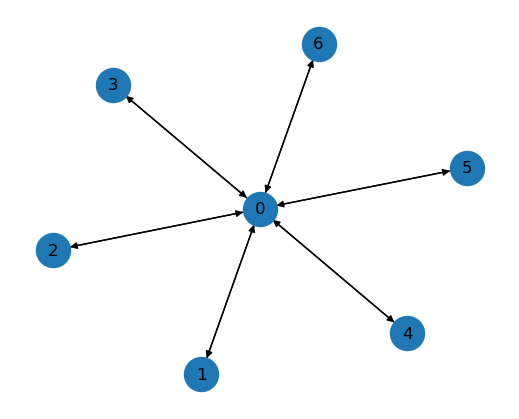

In [4]:

# star edges: 0 -> {1..6}
edge_index = torch.tensor([[0,0,0,0,0,0],
                           [1,2,3,4,5,6]], dtype=torch.long)

# make undirected (adds reverse edges)
edge_index = to_undirected(edge_index)
num_edges = edge_index.size(1)

# node features: 7 nodes, 1 feature each
x = torch.tensor([[0], [0], [0], [0], [0], [1], [1]], dtype=torch.float)

# edge features: match number of edges
edge_attr = torch.rand(num_edges, 1, dtype=torch.float)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
print(data)  # e.g., Data(edge_attr=[12, 1], edge_index=[2, 12], x=[7, 1])

# visualize with networkx
G = to_networkx(data, node_attrs=["x"], edge_attrs=["edge_attr"])
plt.figure(figsize=(5,4))
pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos, with_labels=True, node_size=600)
plt.show()

# --- DGL equivalent (optional) ---
# import dgl
# g = dgl.graph((edge_index[0], edge_index[1]), num_nodes=x.size(0))
# g = dgl.to_bidirected(g, copy_ndata=True, copy_edata=True)
# print(g)


# Dataset

In [30]:
# assumes these are defined in earlier cells:
# graph_type, fold, path_embeddings, embedding_layer, model_name, patch_size, magnifications
# is_neighbors, natural_keys

# --- switches for within-mag edge construction ---
USE_SIMILARITY   = True     # True: cosine-similarity edges, False: distance-based (is_neighbors)
SIM_THRESHOLD    = 0.85     # cosine similarity threshold (0.7–0.95 typical)
ALLOW_SELF_LOOPS = False    # connect patch to itself?

class VPCDataset(Dataset):
    def __init__(self, root, fold, magnifications, path_outcomes=None,
                 transform=None, pre_transform=None, pre_filter=None,
                 labels_csv=None):
        self.fold = fold
        self.magnifications = list(magnifications)
        self.embeddings_root = os.path.join(root, fold)  # e.g., 256_VPC_embeddings/fold1

        # Label source (optional)
        self.core2label = None
        if labels_csv is not None:
            df = pd.read_csv(labels_csv)
            df = df.assign(core=df["path"].apply(lambda p: p.split("/")[-4]))
            core_labels = (
                df.groupby("core")["hard_label"]
                  .agg(lambda s: int(pd.Series(s).mode().iloc[0]))
                  .to_dict()
            )
            self.core2label = core_labels
        elif path_outcomes is not None:
            self.df = pd.read_csv(path_outcomes).reset_index(drop=True)

        super().__init__(os.path.join(root, fold), transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return ['_embeddings_ready']

    # >>> CHANGED: use processed_plus instead of processed
    @property
    def processed_dir(self) -> str:
        return os.path.join(self.root, f'processed_plus_{SIM_THRESHOLD}')

    @property
    def processed_file_names(self):
        proc_dir = self.processed_dir
        if os.path.isdir(proc_dir):
            files = [f for f in os.listdir(proc_dir) if f.endswith(f'_{graph_type}.pt')]
            return files if files else ['_placeholder.pt']
        return ['_placeholder.pt']

    def download(self):
        pass

    def process(self):
        base = self.embeddings_root
        if not os.path.isdir(base):
            raise FileNotFoundError(f"Embeddings directory not found: {base}")

        # ensure the new output dir exists
        os.makedirs(self.processed_dir, exist_ok=True)

        cores = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))]
        cores = [c for c in cores if c != '.ipynb_checkpoints']

        mags_req = self.magnifications
        patch_size_local = patch_size

        for idx, core in enumerate(cores, 1):
            print(f'{core}, {idx}/{len(cores)}')

            y = int(self.core2label.get(core, -1)) if self.core2label is not None else -1

            # load embeddings dicts for requested magnifications
            embd_paths = []
            for mag in mags_req:
                embd_path = os.path.join(base, core, str(patch_size_local), str(mag),
                                         f'{model_name}_{embedding_layer}.pkl')
                if os.path.isfile(embd_path):
                    embd_paths.append((mag, embd_path))
            if len(embd_paths) == 0:
                continue

            embd_paths.sort(key=lambda t: mags_req.index(t[0]))
            used_mags = [mag for mag, _ in embd_paths]
            embd_dicts = []
            for _, pkl_path in embd_paths:
                with open(pkl_path, 'rb') as f:
                    embd_dicts.append(pickle.load(f))

            # normalize embeddings once for cosine similarity
            embd_norm = []
            for d in embd_dicts:
                d_norm = {}
                for k, v in d.items():
                    v = np.asarray(v, dtype=np.float32)
                    n = np.linalg.norm(v) + 1e-12
                    d_norm[k] = v / n
                embd_norm.append(d_norm)

            dict_keys = list(embd_dicts[0].keys())
            dict_keys.sort(key=natural_keys)
            dict_keys = [k for k in dict_keys if k != '.ipynb_checkpo']

            m_present = len(embd_dicts)
            N = len(dict_keys)
            x_np = np.zeros((m_present, N, 512), dtype=np.float32)
            edge = []
            edge_type_size = {}

            # within-mag edges (similarity or distance)
            for k, embd_dict in enumerate(embd_dicts):
                for i, key in enumerate(dict_keys):
                    x_np[k, i] = embd_dict[key]
                for i, key in enumerate(dict_keys):
                    for j, key_n in enumerate(dict_keys):
                        if not ALLOW_SELF_LOOPS and key == key_n:
                            continue
                        if USE_SIMILARITY:
                            cond = is_similar(key, key_n, embd_norm, k, SIM_THRESHOLD)
                            # add this mutual check (cheap): j must also see i above threshold
                            if cond:
                                cond = is_similar(key_n, key, embd_norm, k, SIM_THRESHOLD)
                        else:
                            cond = is_neighbors(key, key_n, patch_size_local)
                        if cond:
                            edge.append([i * m_present + k, j * m_present + k])
                            et = f"{used_mags[k]}_{used_mags[k]}"
                            edge_type_size[et] = edge_type_size.get(et, 0) + 1

            # cross-mag consecutive links (bidirectional)
            for k in range(m_present - 1):
                lm, rm = used_mags[k], used_mags[k + 1]
                et = f"{lm}_{rm}"; et_rev = f"{rm}_{lm}"
                edge_type_size.setdefault(et, 0)
                edge_type_size.setdefault(et_rev, 0)
                for i in range(N):
                    edge.append([i * m_present + k,     i * m_present + (k + 1)])
                    edge.append([i * m_present + (k+1), i * m_present + k])
                    edge_type_size[et]     += 1
                    edge_type_size[et_rev] += 1

            # flatten features in column-major order
            x_np = np.reshape(x_np, (x_np.shape[0] * x_np.shape[1], x_np.shape[2]), order='F')

            # edge_index
            edge_index = torch.tensor(edge, dtype=torch.long).t().contiguous() if len(edge) else \
                         torch.empty((2, 0), dtype=torch.long)

            # edge_type ids in append order
            edge_type_blocks = []
            for k in range(m_present):
                et = f"{used_mags[k]}_{used_mags[k]}"
                edge_type_blocks.extend([et] * edge_type_size.get(et, 0))
            for k in range(m_present - 1):
                et = f"{used_mags[k]}_{used_mags[k+1]}"
                edge_type_blocks.extend([et] * edge_type_size.get(et, 0))
                et_rev = f"{used_mags[k+1]}_{used_mags[k]}"
                edge_type_blocks.extend([et_rev] * edge_type_size.get(et_rev, 0))

            etype_to_id, edge_type_ids = {}, []
            for et in edge_type_blocks:
                if et not in etype_to_id:
                    etype_to_id[et] = len(etype_to_id)
                edge_type_ids.append(etype_to_id[et])
            edge_type = torch.tensor(edge_type_ids, dtype=torch.long) if edge_type_ids else None

            data = Data(
                x=torch.from_numpy(x_np),
                edge_index=edge_index,
                y=torch.tensor([y], dtype=torch.long)
            )
            if graph_type == 'heterogeneous' and edge_type is not None:
                data = data.to_heterogeneous(edge_type=edge_type)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)

            out_name = f'{core}_{graph_type}.pt'
            torch.save(data, os.path.join(self.processed_dir, out_name))

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, self.processed_file_names[idx]))
        return data

In [31]:
labels_csv = '../data/VPC/patch_labels_majority.csv'
magnifications = [10,20,40]

dataset = VPCDataset(
    root=path_embeddings,
    fold=fold,
    magnifications=magnifications,   # e.g., [40] or [10,20,40]
    labels_csv=labels_csv            
)

Processing...


slide006_core029, 1/248
slide006_core100, 2/248
slide003_core031, 3/248
slide005_core091, 4/248
slide003_core069, 5/248
slide001_core010, 6/248
slide007_core005, 7/248
processed, 8/248
slide006_core077, 9/248
slide001_core005, 10/248
slide006_core105, 11/248
slide003_core023, 12/248
slide006_core019, 13/248
slide005_core118, 14/248
slide001_core059, 15/248
slide001_core086, 16/248
slide006_core109, 17/248
slide005_core038, 18/248
slide003_core075, 19/248
slide003_core108, 20/248
slide001_core039, 21/248
slide006_core093, 22/248
slide001_core040, 23/248
slide002_core071, 24/248
slide006_core004, 25/248
slide001_core095, 26/248
slide005_core034, 27/248
slide007_core016, 28/248
slide002_core026, 29/248
slide006_core010, 30/248
slide006_core047, 31/248
slide005_core104, 32/248
slide006_core098, 33/248
raw, 34/248
slide001_core038, 35/248
slide002_core145, 36/248
slide003_core080, 37/248
slide007_core047, 38/248
slide005_core112, 39/248
slide007_core146, 40/248
slide006_core155, 41/248
slid

Done!


In [7]:
print(len(dataset))

244


In [8]:
a = np.array([[[1,2],[3,4]],[[5,6],[7,8]], [[9,10],[11,12]]])
print(a)

[[[ 1  2]
  [ 3  4]]

 [[ 5  6]
  [ 7  8]]

 [[ 9 10]
  [11 12]]]


In [9]:
print(np.reshape(a, (3*2,2), order='F'))

[[ 1  2]
 [ 5  6]
 [ 9 10]
 [ 3  4]
 [ 7  8]
 [11 12]]


In [ ]:
import os, torch, numpy as np, pandas as pd

# ---- set these if not already defined in your notebook ----
graphs_root = path_embeddings
fold        = 'fold1'
graph_type  = 'heterogeneous'  # or 'homogeneous', '40', etc.

old_dir = os.path.join(graphs_root, fold, 'processed')
new_dir = os.path.join(graphs_root, fold, f'processed_plus_{SIM_THRESHOLD}')
pattern = f'_{graph_type}.pt'

def _flatten_edges(data):
    """Return a single [2, E] edge_index for Data or HeteroData."""
    if hasattr(data, 'edge_index'):
        return data.edge_index
    # HeteroData: concat all edge types
    ei_list = [data.edge_index_dict[t] for t in getattr(data, 'edge_types', [])]
    if not ei_list:
        return torch.empty((2, 0), dtype=torch.long)
    return torch.cat(ei_list, dim=1)

def _num_nodes(data):
    """Return total node count (works for our single node type '0' or sum across types)."""
    if hasattr(data, 'num_nodes'):
        return int(data.num_nodes)
    if '0' in getattr(data, 'node_types', []):
        return int(data['0'].num_nodes)
    return int(sum(data[nt].num_nodes for nt in data.node_types))

def _graph_metrics(data):
    N = _num_nodes(data)
    ei = _flatten_edges(data).cpu().numpy()
    E_dir = ei.shape[1]
    self_loops = int((ei[0] == ei[1]).sum()) if E_dir else 0
    # unique undirected edges (ignore direction)
    if E_dir:
        a = np.minimum(ei[0], ei[1])
        b = np.maximum(ei[0], ei[1])
        und = np.unique(np.stack([a, b], axis=1), axis=0)
        E_und = und.shape[0]
    else:
        E_und = 0
    # densities
    if N > 1:
        dens_dir = E_dir / (N * (N - 1))          # directed, no self-loops in denom
        dens_und = (2 * E_und) / (N * (N - 1))    # undirected density
    else:
        dens_dir = float('nan'); dens_und = float('nan')
    mean_outdeg = E_dir / N if N > 0 else 0.0
    mean_deg_und = (2 * E_und) / N if N > 0 else 0.0

    # per-relation counts (only for hetero)
    per_rel = {}
    if not hasattr(data, 'edge_index') and hasattr(data, 'edge_types'):
        for t in data.edge_types:
            per_rel[str(t)] = int(data.edge_index_dict[t].shape[1])

    return dict(N=N, E_dir=E_dir, E_und=E_und, self_loops=self_loops,
                dens_dir=dens_dir, dens_und=dens_und,
                mean_outdeg=mean_outdeg, mean_deg_und=mean_deg_und,
                per_rel=per_rel)

def _scan_dir(d):
    rows = []
    if not os.path.isdir(d):
        print(f"[warn] missing directory: {d}")
        return pd.DataFrame()
    for f in os.listdir(d):
        if f.endswith(pattern):
            data = torch.load(os.path.join(d, f), map_location='cpu', weights_only=False)
            m = _graph_metrics(data)
            m['file'] = f
            rows.append(m)
    df = pd.DataFrame(rows)
    if not df.empty:
        df['core'] = df['file'].str.replace(pattern, '', regex=False)
    return df

df_old = _scan_dir(old_dir)
df_new = _scan_dir(new_dir)

def _summ(df, tag):
    if df.empty:
        print(f"[{tag}] no graphs found.")
        return
    print(f"\n[{tag}] graphs: {len(df)}")
    print(df[['N','E_dir','E_und','self_loops','dens_dir','dens_und','mean_outdeg','mean_deg_und']].describe().round(4))

print(f"Comparing graphs in:\n  OLD: {old_dir}\n  NEW: {new_dir}\n  pattern: *{pattern}")

_summ(df_old, "OLD")
_summ(df_new, "NEW")

# Merge on core to compare same graphs
if not df_old.empty and not df_new.empty:
    m = pd.merge(
        df_old[['core','N','E_dir','E_und','dens_dir','dens_und','mean_deg_und']],
        df_new[['core','N','E_dir','E_und','dens_dir','dens_und','mean_deg_und']],
        on='core', suffixes=('_old','_new')
    )

    if not m.empty:
        for col in ['E_dir','E_und','dens_dir','dens_und','mean_deg_und']:
            m[f'{col}_delta'] = m[f'{col}_new'] - m[f'{col}_old']
            m[f'{col}_ratio'] = np.divide(m[f'{col}_new'], m[f'{col}_old'].replace(0, np.nan))

        print("\n[Delta summary over common cores] (new - old):")
        print(m[[c for c in m.columns if c.endswith('_delta')]].describe().round(4))

        # Top cores with largest increase in undirected mean degree
        top = m.sort_values('mean_deg_und_delta', ascending=False).head(10)
        display_cols = ['core','N_old','N_new','E_und_old','E_und_new','mean_deg_und_old','mean_deg_und_new','mean_deg_und_delta']
        print("\n[Top ↑ mean_deg_und cores]")
        print(top[display_cols].round(4).to_string(index=False))
    else:
        print("\nNo overlapping cores between OLD and NEW sets.")
else:
    print("\nAt least one set is empty; skipping pairwise comparison.")

# Optional: inspect per-relation breakdown for a single example graph in each set
def show_rel_breakdown(df, tag):
    if df.empty: return
    f0 = df.iloc[0]['file']
    data = torch.load(os.path.join(old_dir if tag=="OLD" else new_dir, f0), map_location='cpu', weights_only=False)
    if hasattr(data, 'edge_index'):
        print(f"\n[{tag}] {f0}: homogeneous graph, total edges = {data.edge_index.shape[1]}")
    else:
        counts = {str(t): int(data.edge_index_dict[t].shape[1]) for t in data.edge_types}
        print(f"\n[{tag}] {f0}: per-relation edge counts:")
        for k,v in counts.items():
            print(f"  {k}: {v}")

show_rel_breakdown(df_old, "OLD")
show_rel_breakdown(df_new, "NEW")
